[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/examples/simulation_example_SplineFlow.ipynb)

<div class="alert alert-success">
    <center> <h1> <font size="8"> Normalizing Flow Example </font> </h1> </center>
</div>

<br/>
<br/>

<center>
<img src="https://tikz.net/janosh/normalizing-flow.png" width=620 height=620/>
</center>

<span style="text-align: right;">
<h6>Image source: https://tikz.net/janosh/normalizing-flow.png</h6>
</span>

<br/>
<br/>

Normalizing flows transform a simple distribution into a complex data distribution through a series of invertible transformations. The key steps involved in the operation of normalizing flows are as follows (from left to right):

- Start with a simple, easy-to-sample distribution, usually a Gaussian, which serves as the "base" distribution
- Apply a series of invertible transformations to map the samples from the base distribution to the desired complex data distribution
- Each transformation in the flow must be reversible, meaning it has both a forward pass (sampling from the base distribution to the complex distribution) and an inverse pass (mapping samples from the complex distribution back to the base distribution)
- The flow ensures that the probability density function (PDF) of the complex distribution can be analytically calculated using the determinant of the Jacobian matrix resulting from the transformations

By stacking multiple transformations in a sequence, normalizing flows can model **complex and multi-modal distributions** while providing the ability to compute the likelihood of the data and perform efficient sampling in both directions (from base to complex and vice versa). However, it is important to note that since XGBoostLSS is based on a *one vs. all estimation strategy*, where a separate tree is grown for each parameter, estimating many parameters for a large dataset can become computationally expensive. For more details, we refer to our related paper **[Alexander März and Thomas Kneib (2022): *Distributional Gradient Boosting Machines*](https://arxiv.org/abs/2204.00778)**.

# Imports

In [1]:
from xgboostlss.model import *
from xgboostlss.distributions.SplineFlow import *
from xgboostlss.distributions.flow_utils import NormalizingFlowClass
from xgboostlss.datasets.data_loader import load_simulated_gaussian_data
from scipy.stats import norm

import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [2]:
# The data is simulated as a Gaussian, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4 * ((0.3 < x) & (x < 0.5)) + 2 * (x > 0.7)

train, test = load_simulated_gaussian_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Select Normalizing Flow

In the following, we specify a list of candidate normalizing flows. The function *dist_select* returns the negative log-likelihood of each specification. The  normalizing flow with the lowest negative log-likelihood is selected. The function also plots the density of the target variable and the fitted density, using the best suitable  normalizing flow among the specified ones. However, note that choosing the best performing flow based solely on training data may lead to overfitting, since normalizing flows have a higher risk of overfitting compared to parametric distributions. When using normalizing flows, it is crucial to carefully select the specifications to strike a balance between model complexity and generalization ability.

Fitting of candidate normalizing flows completed: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:37<00:00,  2.71s/it]


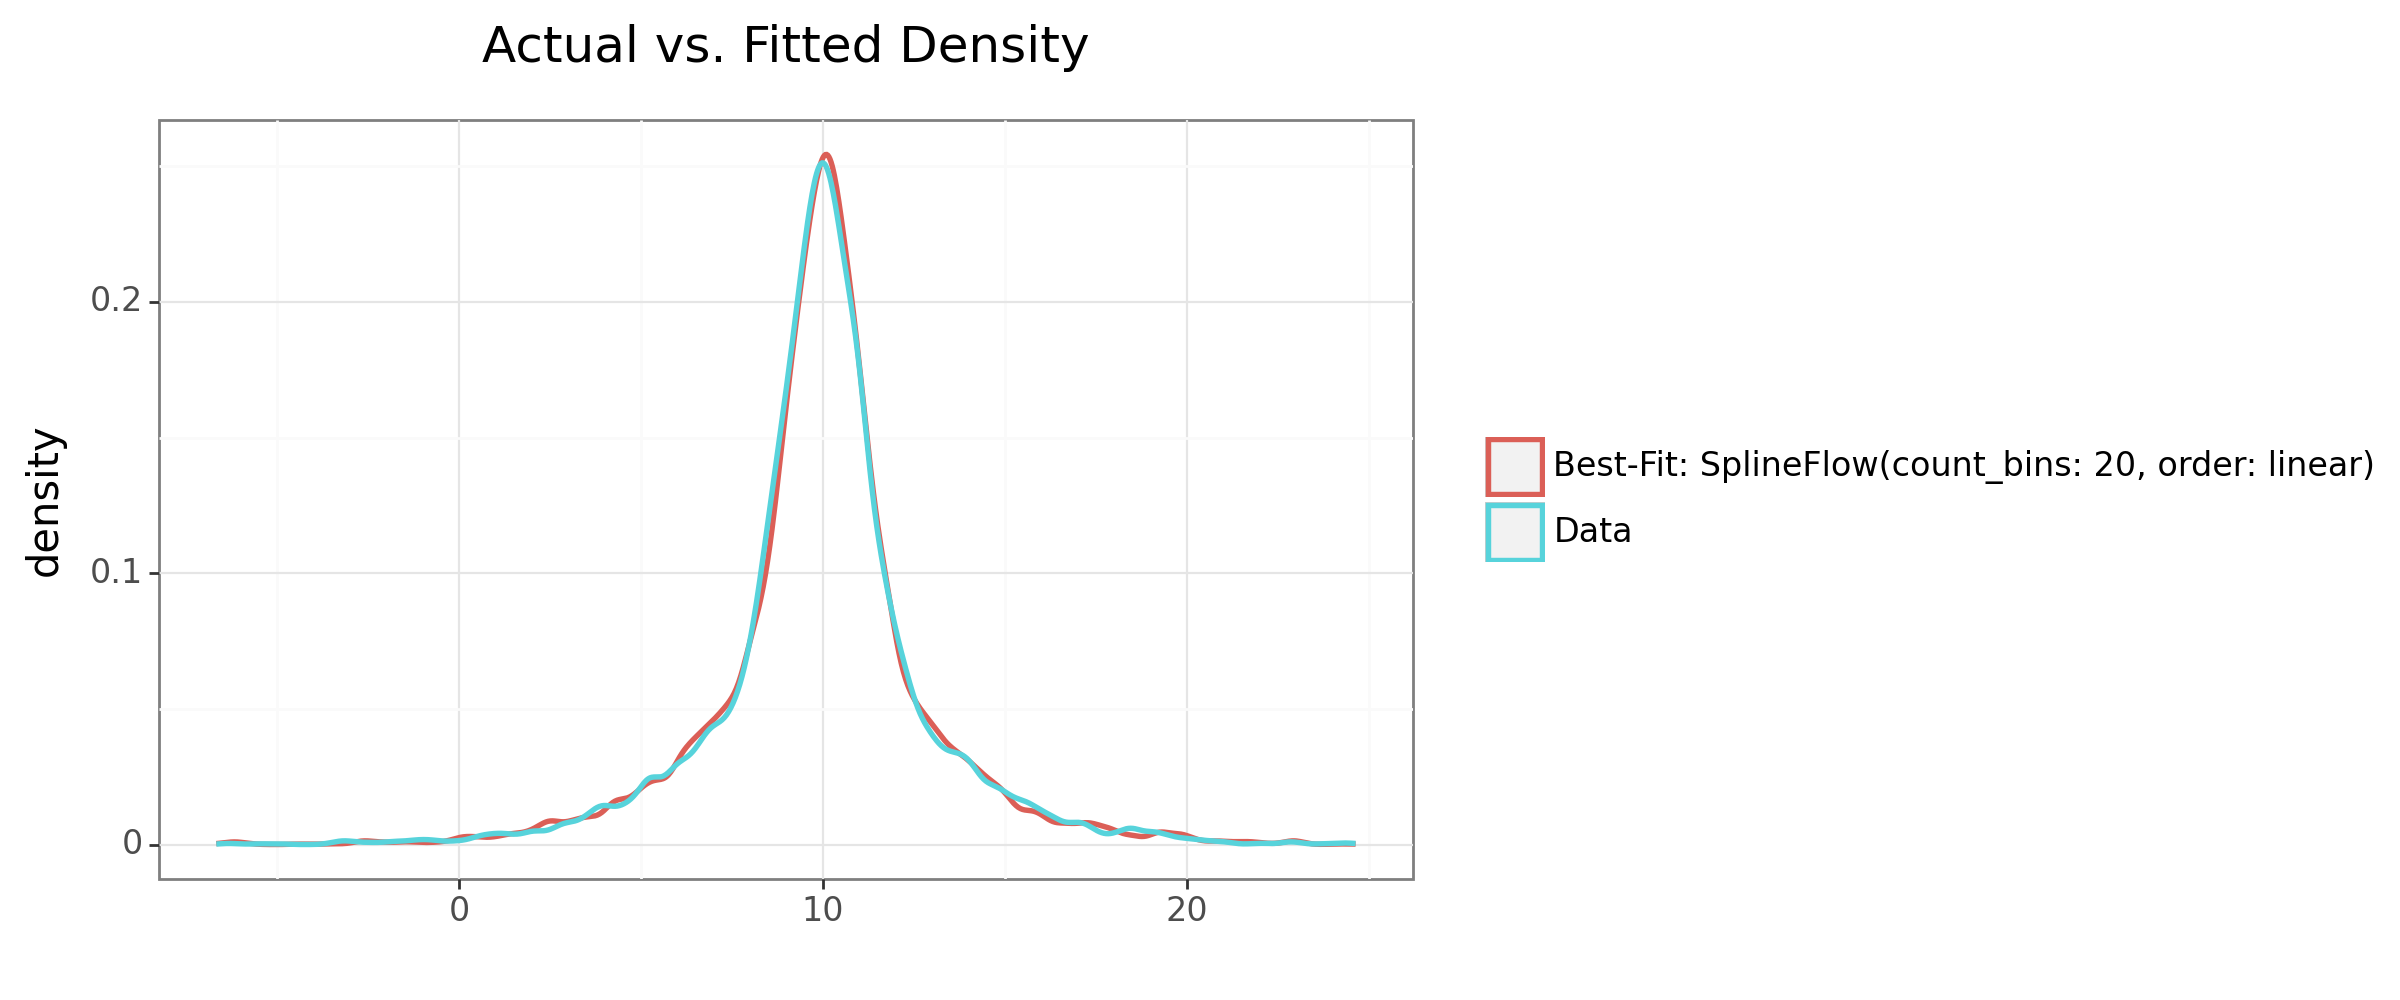

,nll,NormFlow
rank,,
1,16595.917006,"SplineFlow(count_bins: 20, order: linear)"
2,16608.693807,"SplineFlow(count_bins: 12, order: quadratic)"
3,16622.862265,"SplineFlow(count_bins: 16, order: quadratic)"
4,16640.156074,"SplineFlow(count_bins: 6, order: linear)"
5,16640.611035,"SplineFlow(count_bins: 16, order: linear)"
6,16649.404709,"SplineFlow(count_bins: 8, order: linear)"
7,16651.375456,"SplineFlow(count_bins: 8, order: quadratic)"
8,16653.378393,"SplineFlow(count_bins: 6, order: quadratic)"
9,16674.331780,"SplineFlow(count_bins: 12, order: linear)"


In [3]:
# See ?SplineFlow for an overview.
bound = np.max([np.abs(y_train.min()), y_train.max()])
target_support = "real"

candidate_flows = [

    SplineFlow(target_support=target_support, count_bins=2,  bound=bound, order="linear"),
    SplineFlow(target_support=target_support, count_bins=4,  bound=bound, order="linear"),
    SplineFlow(target_support=target_support, count_bins=6,  bound=bound, order="linear"),
    SplineFlow(target_support=target_support, count_bins=8,  bound=bound, order="linear"),
    SplineFlow(target_support=target_support, count_bins=12, bound=bound, order="linear"),
    SplineFlow(target_support=target_support, count_bins=16, bound=bound, order="linear"),
    SplineFlow(target_support=target_support, count_bins=20, bound=bound, order="linear"),

    SplineFlow(target_support=target_support, count_bins=2,  bound=bound, order="quadratic"),
    SplineFlow(target_support=target_support, count_bins=4,  bound=bound, order="quadratic"),
    SplineFlow(target_support=target_support, count_bins=6,  bound=bound, order="quadratic"),
    SplineFlow(target_support=target_support, count_bins=8,  bound=bound, order="quadratic"),
    SplineFlow(target_support=target_support, count_bins=12, bound=bound, order="quadratic"),
    SplineFlow(target_support=target_support, count_bins=16, bound=bound, order="quadratic"),
    SplineFlow(target_support=target_support, count_bins=20, bound=bound, order="quadratic"),
    
] 

flow_nll = NormalizingFlowClass().flow_select(target=y_train, candidate_flows=candidate_flows, max_iter=50, n_samples=10000, plot=True, figure_size=(12, 5))
flow_nll

# Normalizing Flow Specification

Even though SplineFlow(count_bins: 20, order: linear) shows the best fit to the data, we choose a more parameter parsimonious specification (recall that a separate tree is grown for each parameter): 

- for count_bins=20, we need to estimate 3*count_bins + (count_bins-1) = 79 parameters
- for count_bins=8, we need to estimate  3*count_bins + (count_bins-1) = 31 parameters

In [4]:
# Specifies Spline-Flow. See ?SplineFlow for an overview.
bound = np.max([np.abs(y_train.min()), y_train.max()])

xgblss = XGBoostLSS(
    SplineFlow(target_support="real",     # Specifies the support of the target. Options are "real", "positive", "positive_integer" or "unit_interval"
               count_bins=8,              # The number of segments comprising the spline.
               bound=bound,               # By adjusting the value, you can control the size of the bounding box and consequently control the range of inputs that the spline transform operates on.
               order="linear",            # The order of the spline. Options are "linear" or "quadratic".
               stabilization="None",      # Options are "None", "MAD" or "L2".
               loss_fn="nll"              # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
            )    
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [5]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=200,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=1000,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=100,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-07-19 15:42:41,868] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-07-19 15:44:36,791] Trial 0 finished with value: 3332.6613769999994 and parameters: {'eta': 3.3260319803390424e-05, 'max_depth': 6, 'gamma': 0.014616194241901597, 'subsample': 0.26028835908684445, 'colsample_bytree': 0.5991637128218044, 'min_child_weight': 29.134584113650142, 'booster': 'gbtree'}. Best is trial 0 with value: 3332.6613769999994.
[I 2023-07-19 15:46:33,740] Trial 1 finished with value: 3331.4277342 and parameters: {'eta': 4.941359977387702e-05, 'max_depth': 8, 'gamma': 0.00020933183164331635, 'subsample': 0.3380555883792045, 'colsample_bytree': 0.642780063001601, 'min_child_weight': 4.786059202051891, 'booster': 'gbtree'}. Best is trial 1 with value: 3331.4277342.
[I 2023-07-19 15:48:25,031] Trial 2 finished with value: 3331.5851562 and parameters: {'eta': 9.547664319959296e-05, 'max_depth': 7, 'gamma': 5.806690593864706e-08, 'subsample': 0.6290280171604372, 'colsample_bytree': 0.5213798784146892, 'min_child_weight': 112.48236574777444, 'booster': 'gbtree'}. Best

# Model Training

In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [17]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 10000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample9990,y_sample9991,y_sample9992,y_sample9993,y_sample9994,y_sample9995,y_sample9996,y_sample9997,y_sample9998,y_sample9999
0,12.743355,11.383722,4.179454,11.528903,4.430404,14.299993,11.878471,15.049772,9.973994,8.591357,...,14.112717,9.258627,8.018167,11.769898,9.663494,15.706006,5.102396,11.022985,12.035539,6.059301
1,15.862433,8.784878,10.714689,12.784635,8.727695,10.203836,11.958063,10.458128,11.855462,9.305205,...,10.683155,4.115602,11.042725,12.648376,7.617349,14.749219,9.449276,9.809157,5.175217,10.204611
2,12.535251,9.475699,9.557308,11.516135,15.452196,12.027237,11.259157,9.282279,8.994283,10.765754,...,10.195764,11.615862,8.229539,10.616302,8.727758,10.362407,9.887548,7.935420,10.488289,10.363038
3,11.241517,8.765858,13.263488,4.271841,16.312071,16.651518,8.096379,17.387199,7.073308,10.044737,...,0.857149,8.654593,17.208416,7.593403,3.817013,8.726706,13.739422,13.823240,13.596606,9.008204
4,13.770472,8.131836,6.098591,4.307856,5.703317,10.579766,6.353868,15.673490,10.419245,16.967306,...,9.750670,7.598611,8.706325,12.708268,8.645336,7.378088,14.518140,10.732780,7.396825,9.272802


In [9]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,4.799838,15.827713
1,6.375126,14.449861
2,7.627725,13.096555
3,1.483425,18.227258
4,3.364893,16.719298


In [10]:
pred_params.head()

,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,param_9,param_10,...,param_22,param_23,param_24,param_25,param_26,param_27,param_28,param_29,param_30,param_31
0,-0.280689,-0.156779,-0.461753,-0.831503,0.182882,-0.557738,-2.383831,1.173182,0.97675,0.290846,...,0.665089,0.286395,0.945506,0.805746,0.692724,0.634053,-1.548269,4.543334,0.745495,1.069772
1,-0.280689,-0.156779,-0.461753,-0.831503,0.182882,-0.557738,-2.383831,1.173182,0.97675,0.290846,...,0.452529,0.286395,0.945506,0.805746,0.692724,0.634053,-1.759314,4.228522,0.745495,1.069772
2,-0.280689,-0.156779,-0.461753,-0.831503,0.182882,-0.557738,-2.383831,1.173182,0.97675,0.290846,...,0.168802,0.286395,0.945506,0.805746,0.692724,0.634053,-2.541279,4.597850,0.745495,1.069772
3,-0.280689,-0.156779,-0.461753,-0.831503,0.182882,-0.557738,-2.383831,1.173182,0.97675,0.290846,...,0.080688,0.286395,0.945506,0.805746,0.692724,0.634053,0.155015,1.680825,0.745495,1.069772
4,-0.280689,-0.156779,-0.461753,-0.831503,0.182882,-0.557738,-2.383831,1.173182,0.97675,0.290846,...,0.267505,0.286395,0.945506,0.805746,0.692724,0.634053,-0.958130,4.396050,0.745495,1.069772


# SHAP Interpretability

Note that in contrast to parametric distributions, the parameters of the Spline-Flow do not have a direct interpretation.

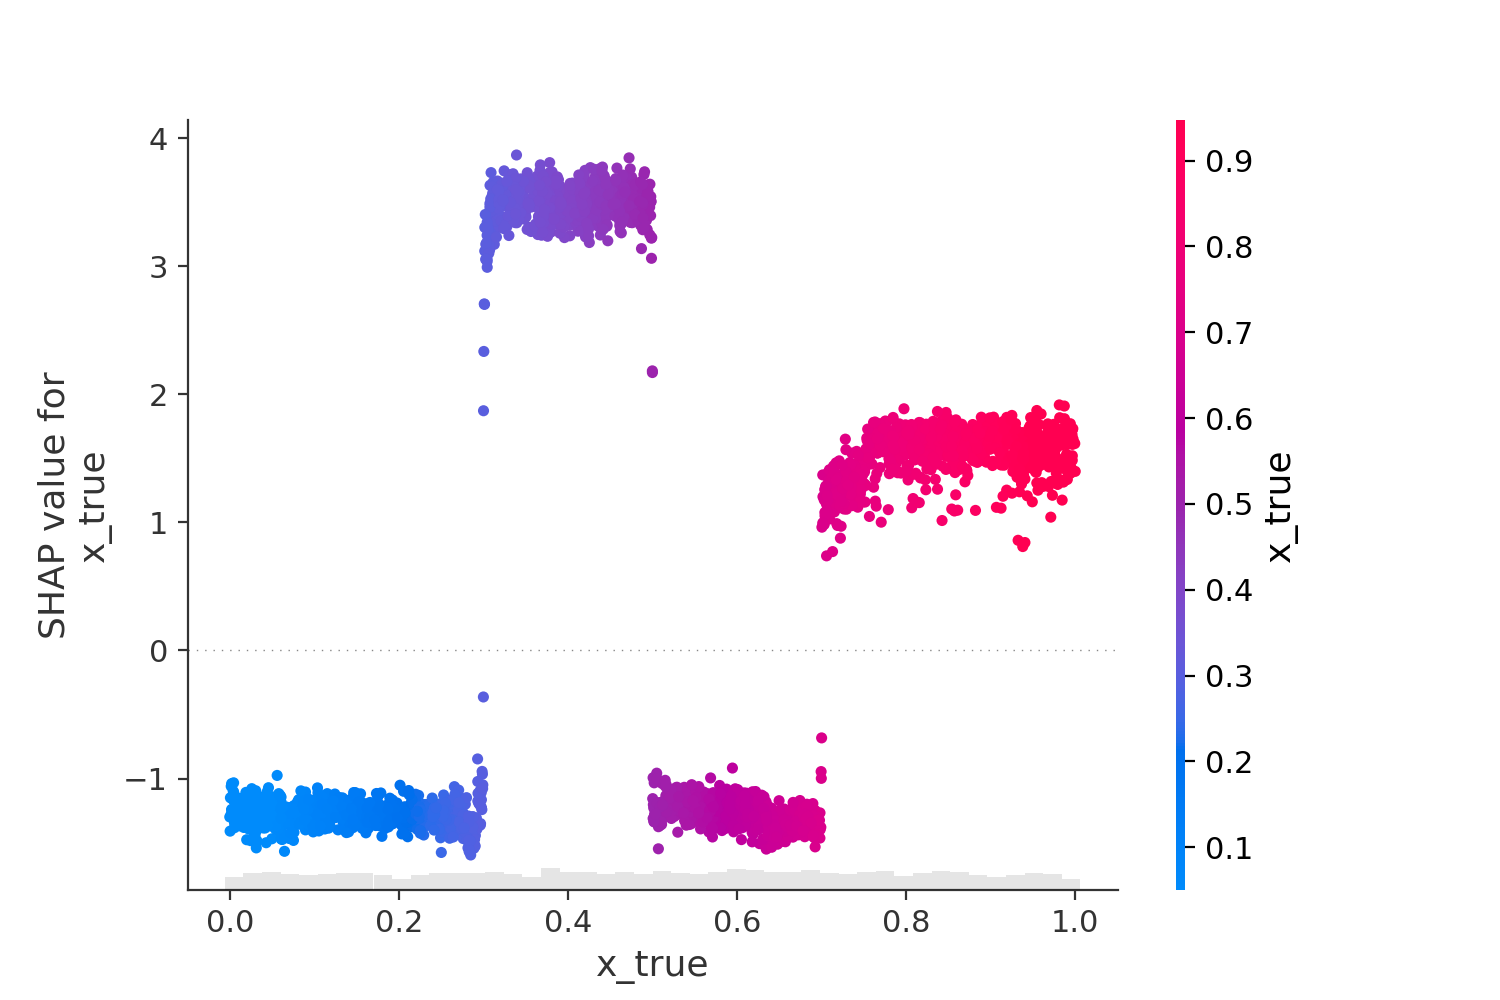

In [11]:
# Partial Dependence Plot of how x acts on param_21
xgblss.plot(X_test,
            parameter="param_21",
            feature="x_true",
            plot_type="Partial_Dependence")

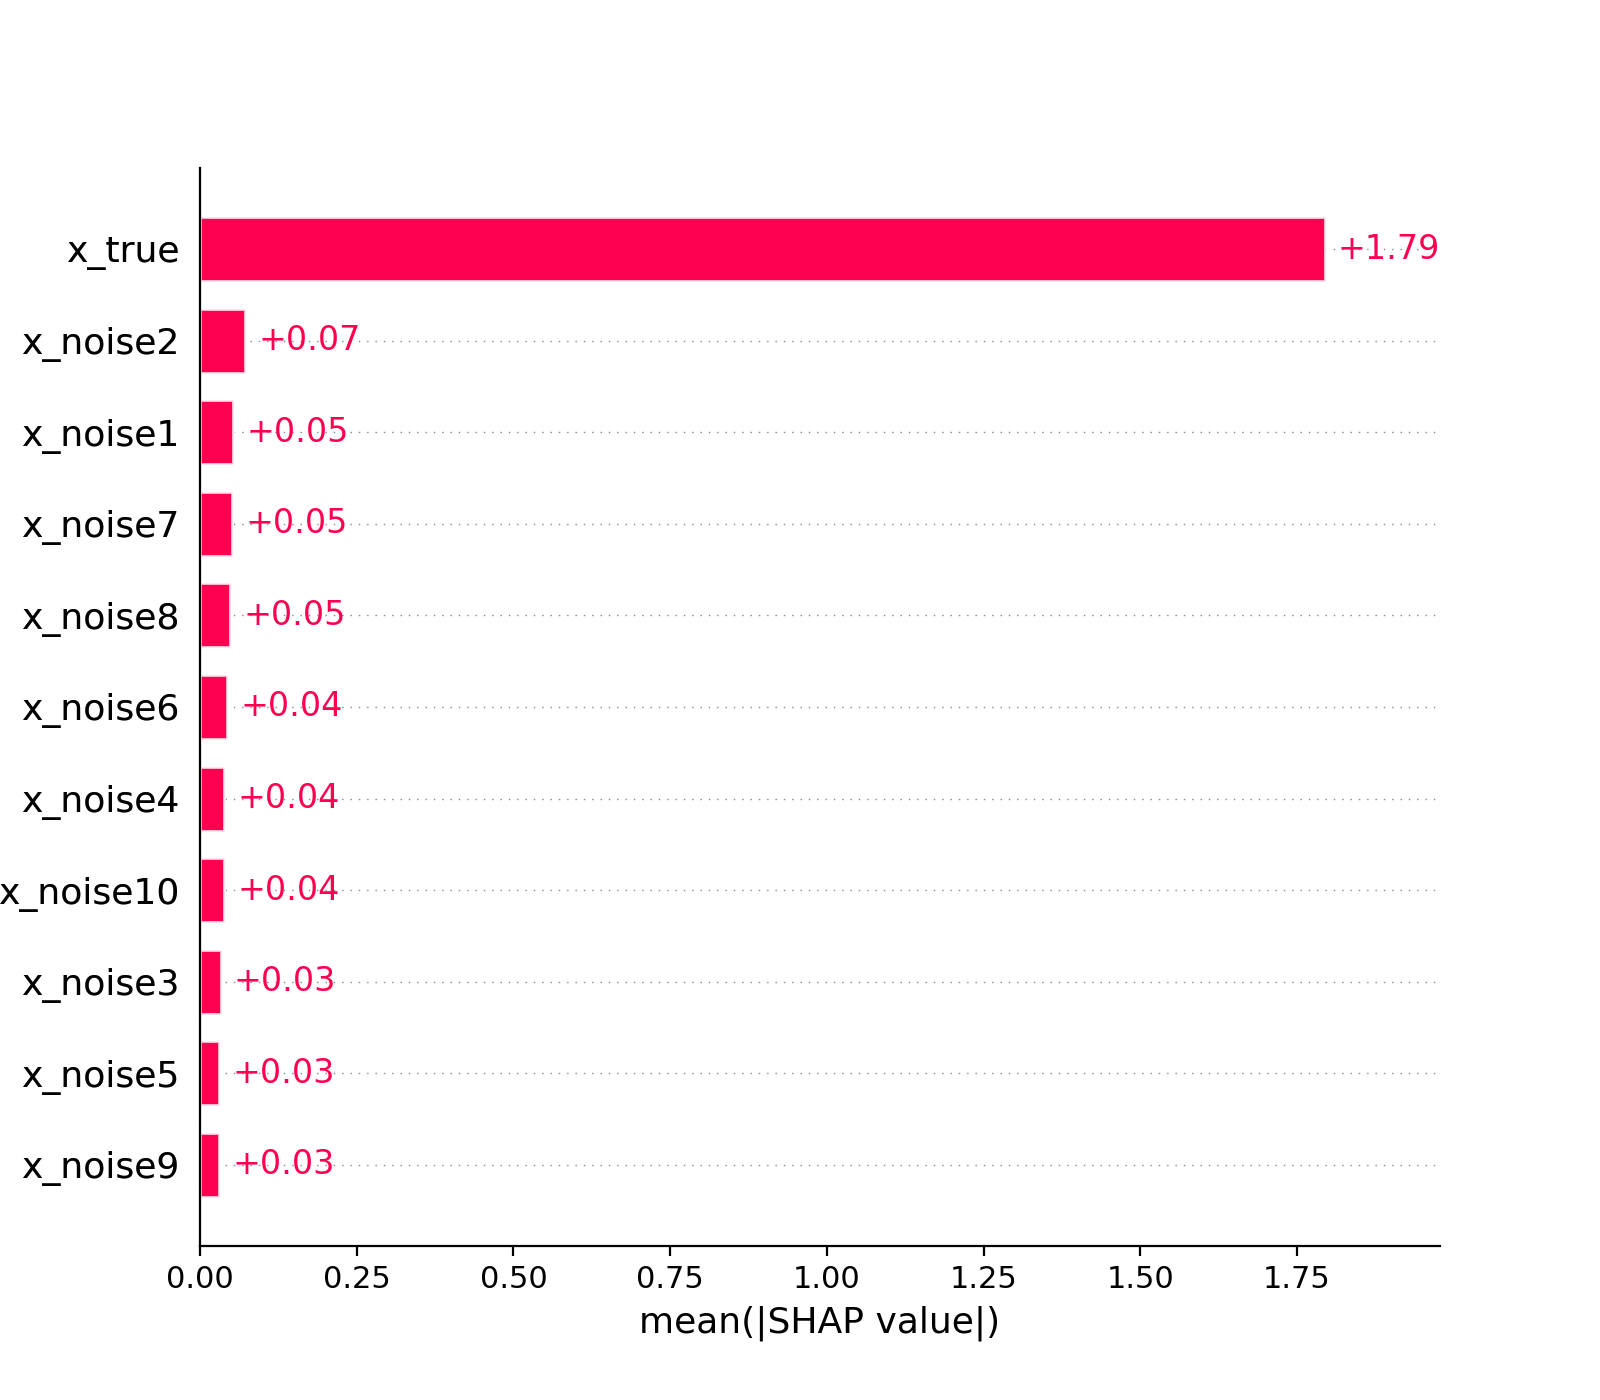

In [12]:
# Feature Importance of param_21
xgblss.plot(X_test,
            parameter="param_21",
            plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

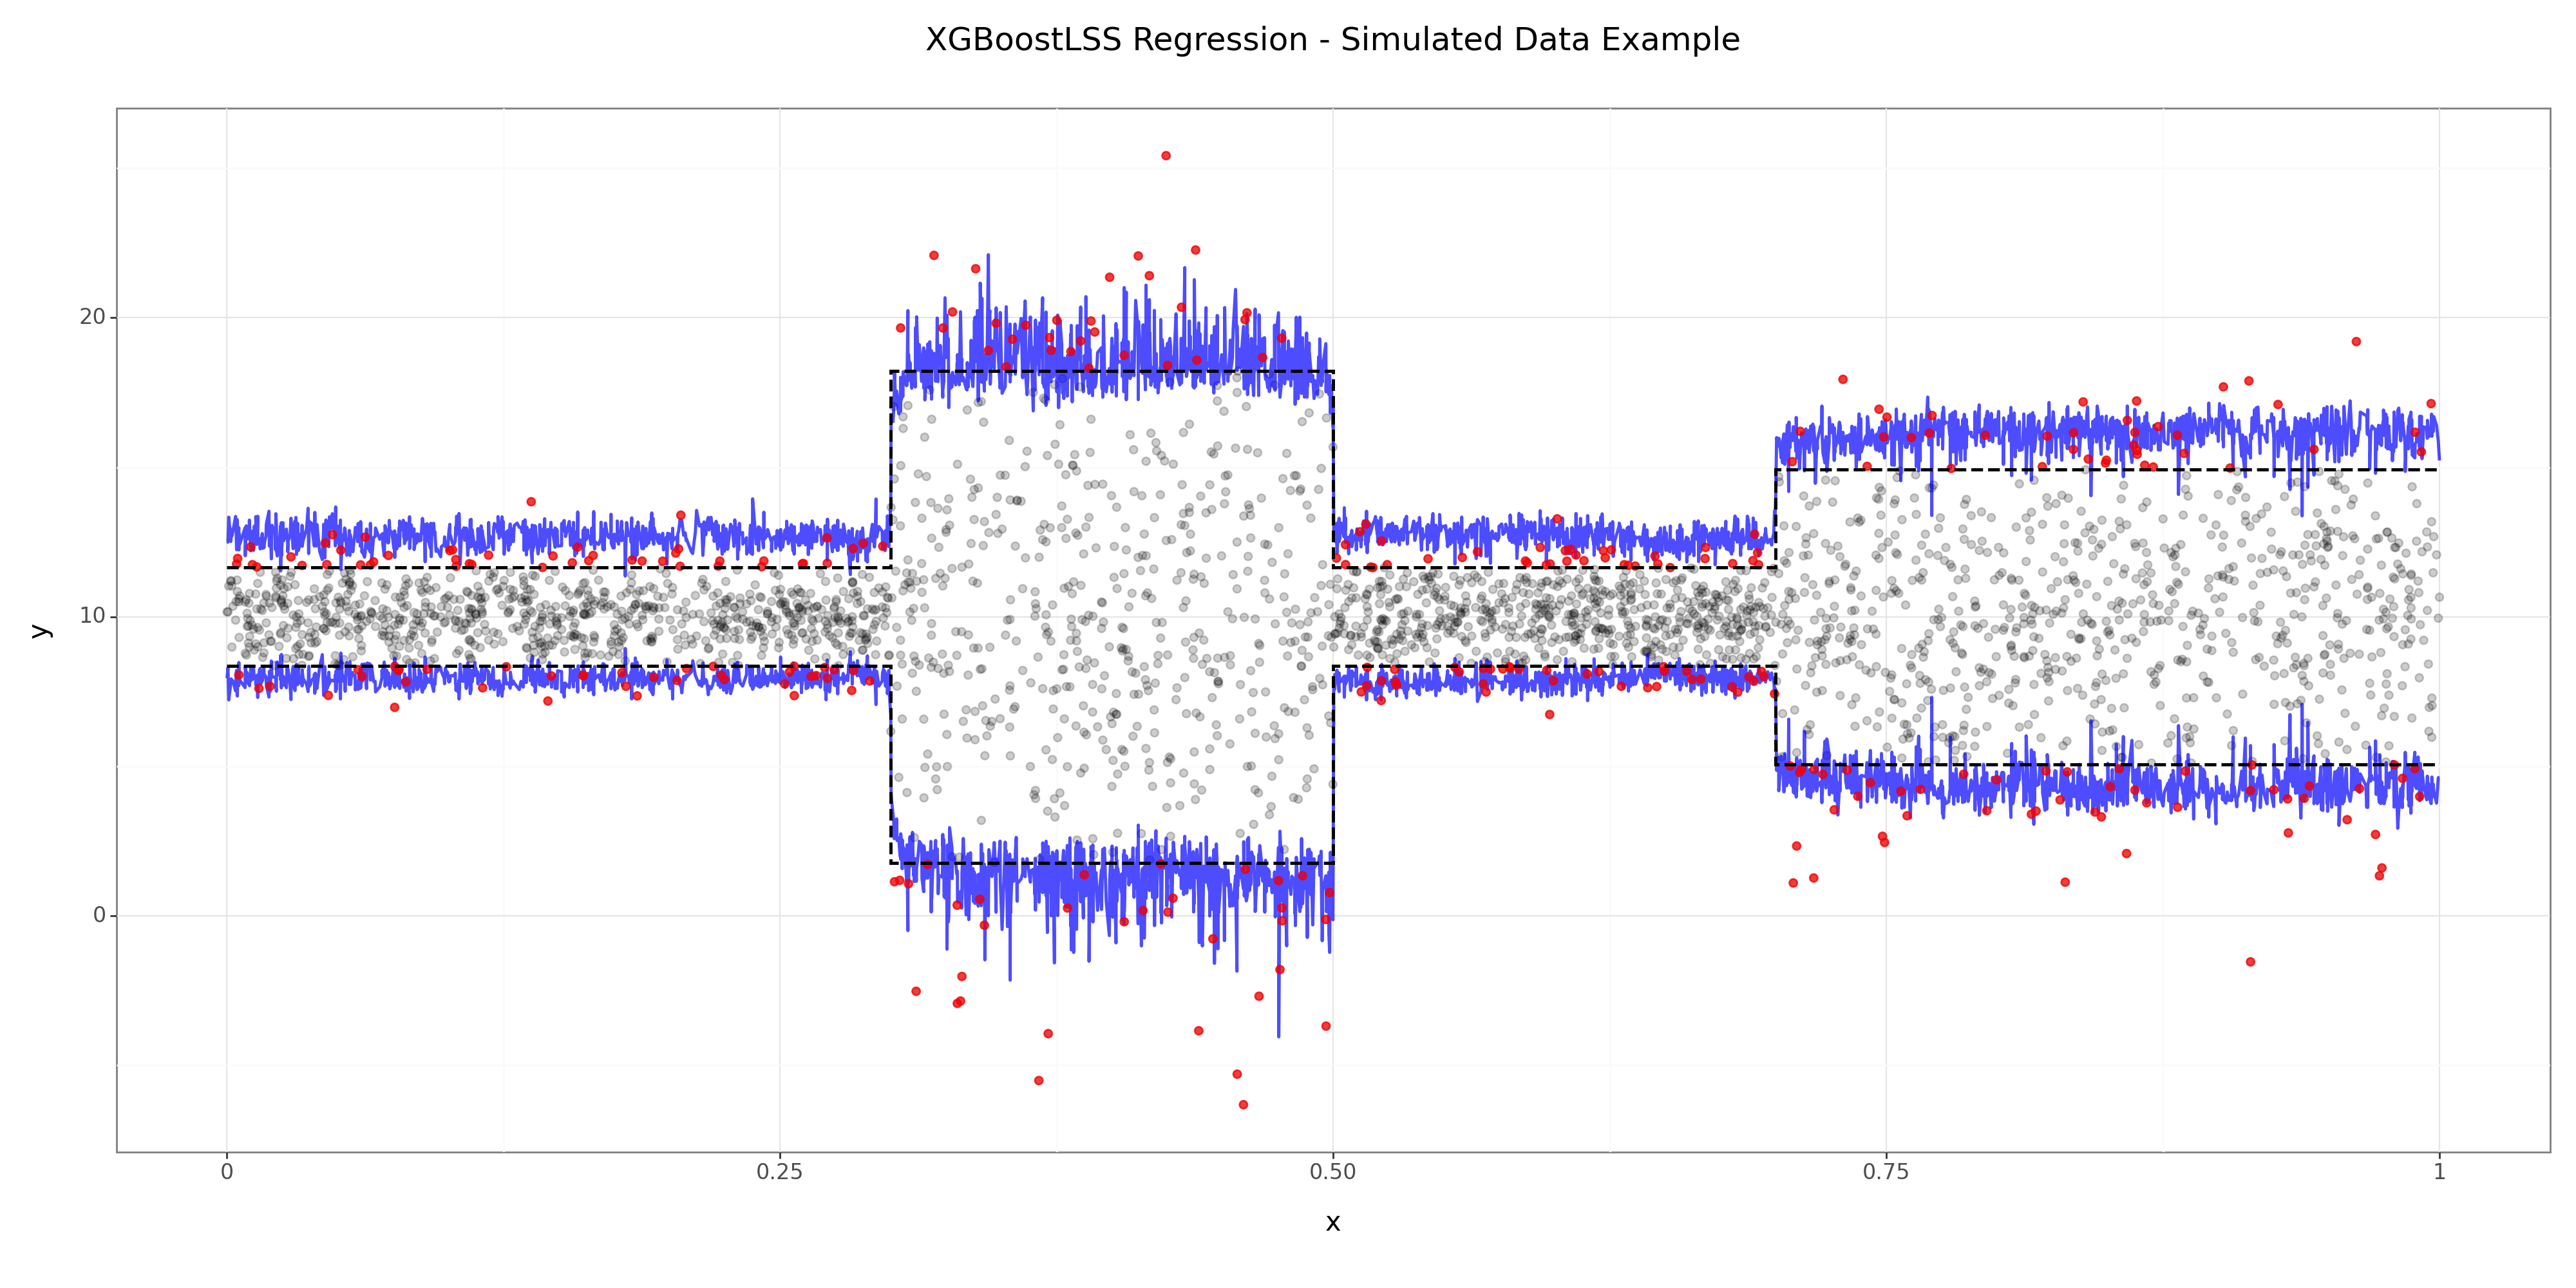

<Figure Size: (2000 x 1000)>

In [18]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x_true"].values) & (test["x_true"].values < 0.5)) + 2*(test["x_true"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x_true"].values) & (test["x_true"].values < 0.5)) + 2*(test["x_true"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1], "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1], "y":yu})

###
# Predicted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]

###
# Plot
###
(ggplot(test,
        aes("x_true",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw(base_size=15) +
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example",
      x="x")  + 
 geom_line(aes("x_true",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x_true",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x_true",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x_true",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x_true",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)

# True vs. Predicted Distributional Parameters

In the following figure, we compare the true parameters of the Gaussian with the ones predicted by XGBoostLSS. The below figure shows that the estimated parameters closely match the true ones (recall that the location parameter $\mu=10$ is simulated as being a constant).

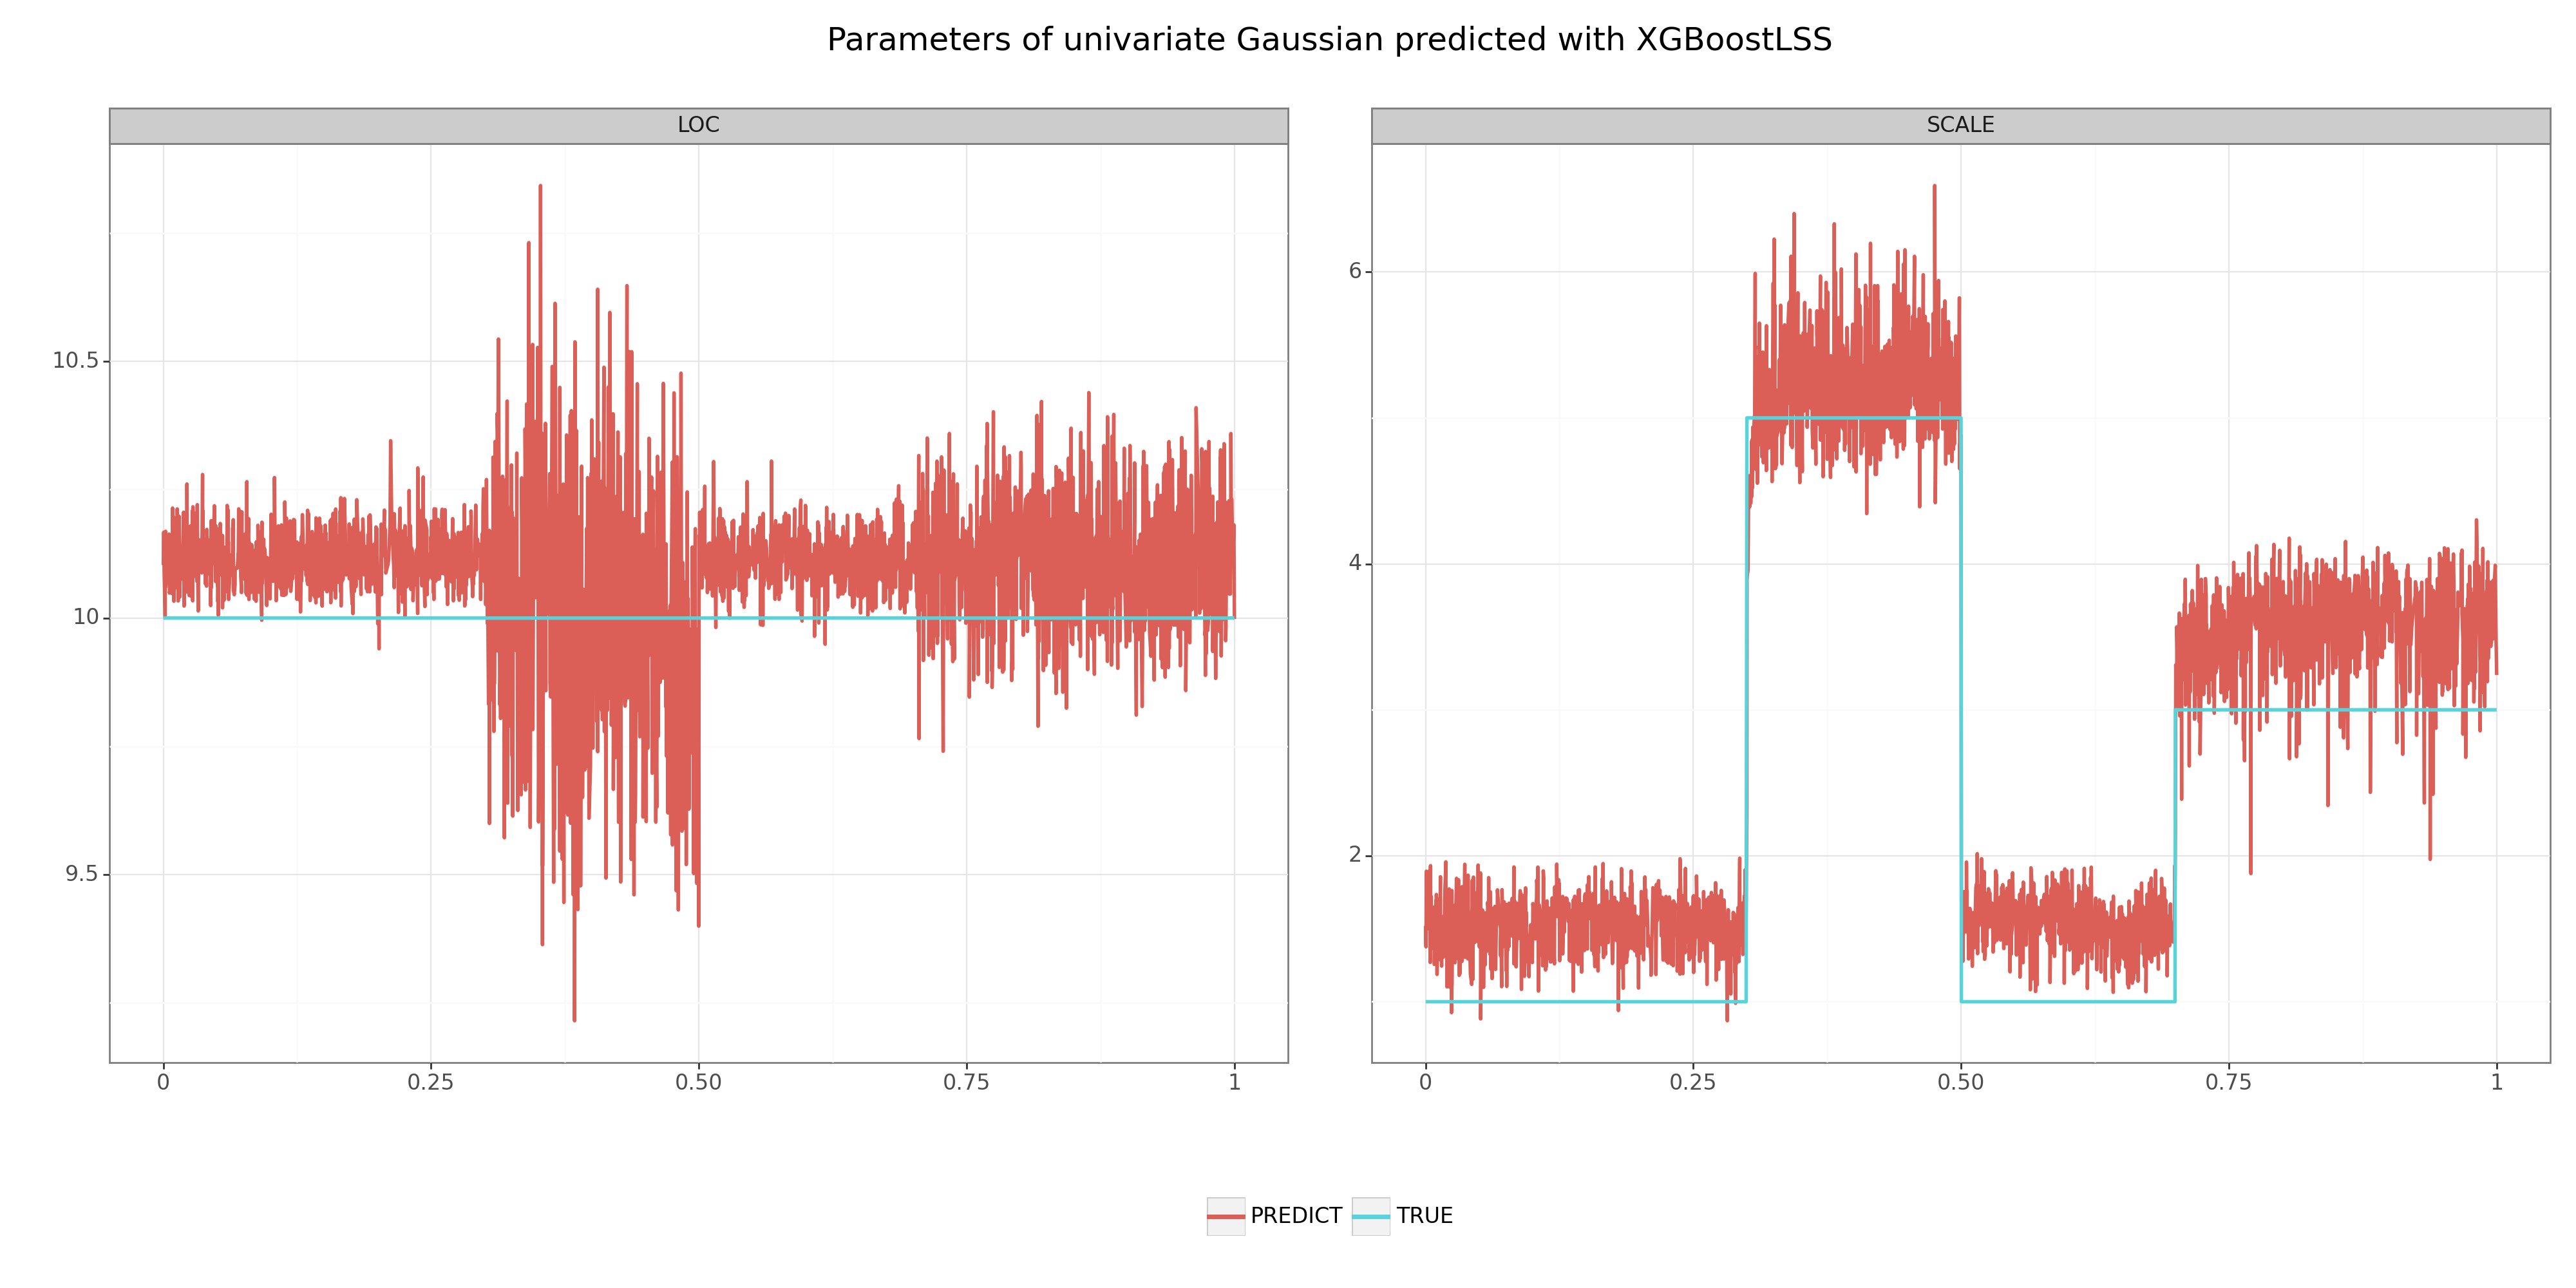

<Figure Size: (2000 x 1000)>

In [19]:
dist_params = ["loc", "scale"]

# Calculate parameters from samples 
sample_params = pd.DataFrame.from_dict(
    {
        "loc": pred_samples.mean(axis=1),
        "scale": pred_samples.std(axis=1),
        "x_true": X_test["x_true"].values        
    }
)

# Data with predicted values
plot_df_predt = pd.melt(sample_params[["x_true"] + dist_params],
                        id_vars="x_true",
                        value_vars=dist_params)
plot_df_predt["type"] = "PREDICT"

# Data with actual values
plot_df_actual = pd.melt(test[["x_true"] + dist_params],
                         id_vars="x_true",
                         value_vars=dist_params)
plot_df_actual["type"] = "TRUE"

# Combine data for plotting
plot_df = pd.concat([plot_df_predt, plot_df_actual])
plot_df["variable"] = plot_df.variable.str.upper()
plot_df["type"] = pd.Categorical(plot_df["type"], categories = ["PREDICT", "TRUE"])

# Plot
(ggplot(plot_df,
        aes(x="x_true",
            y="value",
            color="type")) +
 geom_line(size=1.1) + 
 facet_wrap("variable",
            scales="free") + 
 labs(title="Parameters of univariate Gaussian predicted with XGBoostLSS",
      x="",
      y="") + 
 theme_bw(base_size=15) + 
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5),
       legend_title = element_blank())
)

# Density Plots

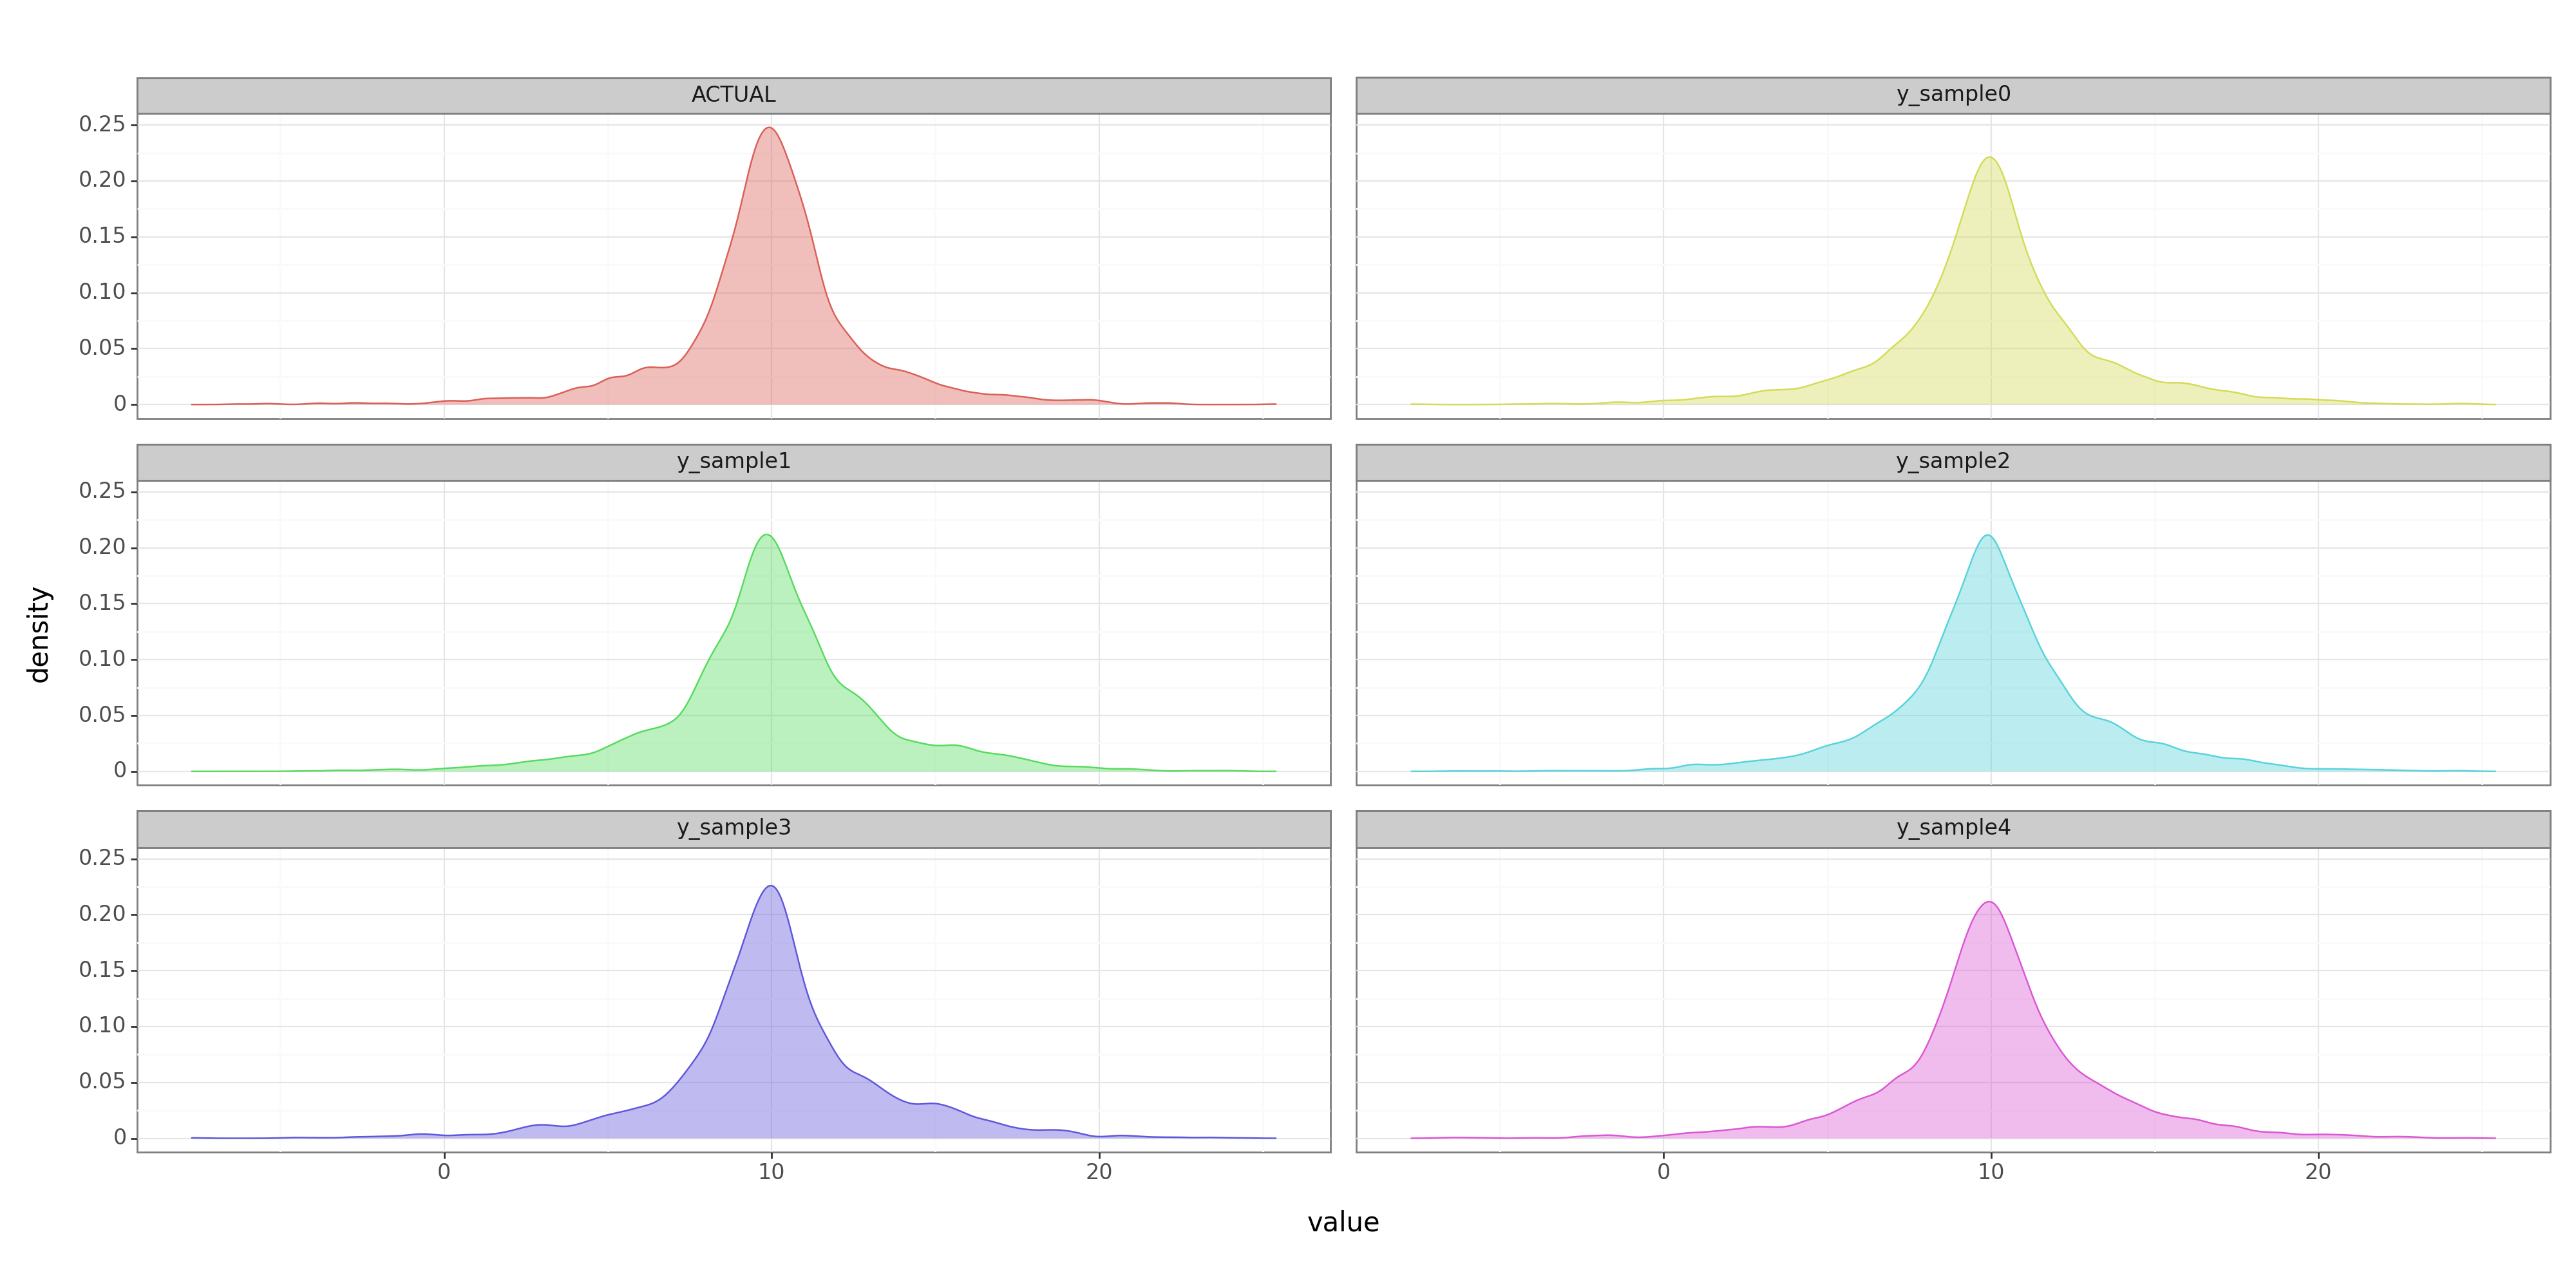

<Figure Size: (2000 x 1000)>

In [20]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
               ncol=2) + 
    theme_bw(base_size=15) + 
    theme(plot_title = element_text(hjust = 0.5)) +
    theme(legend_position="none")
)

# Actual vs. Predicted
Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest. 

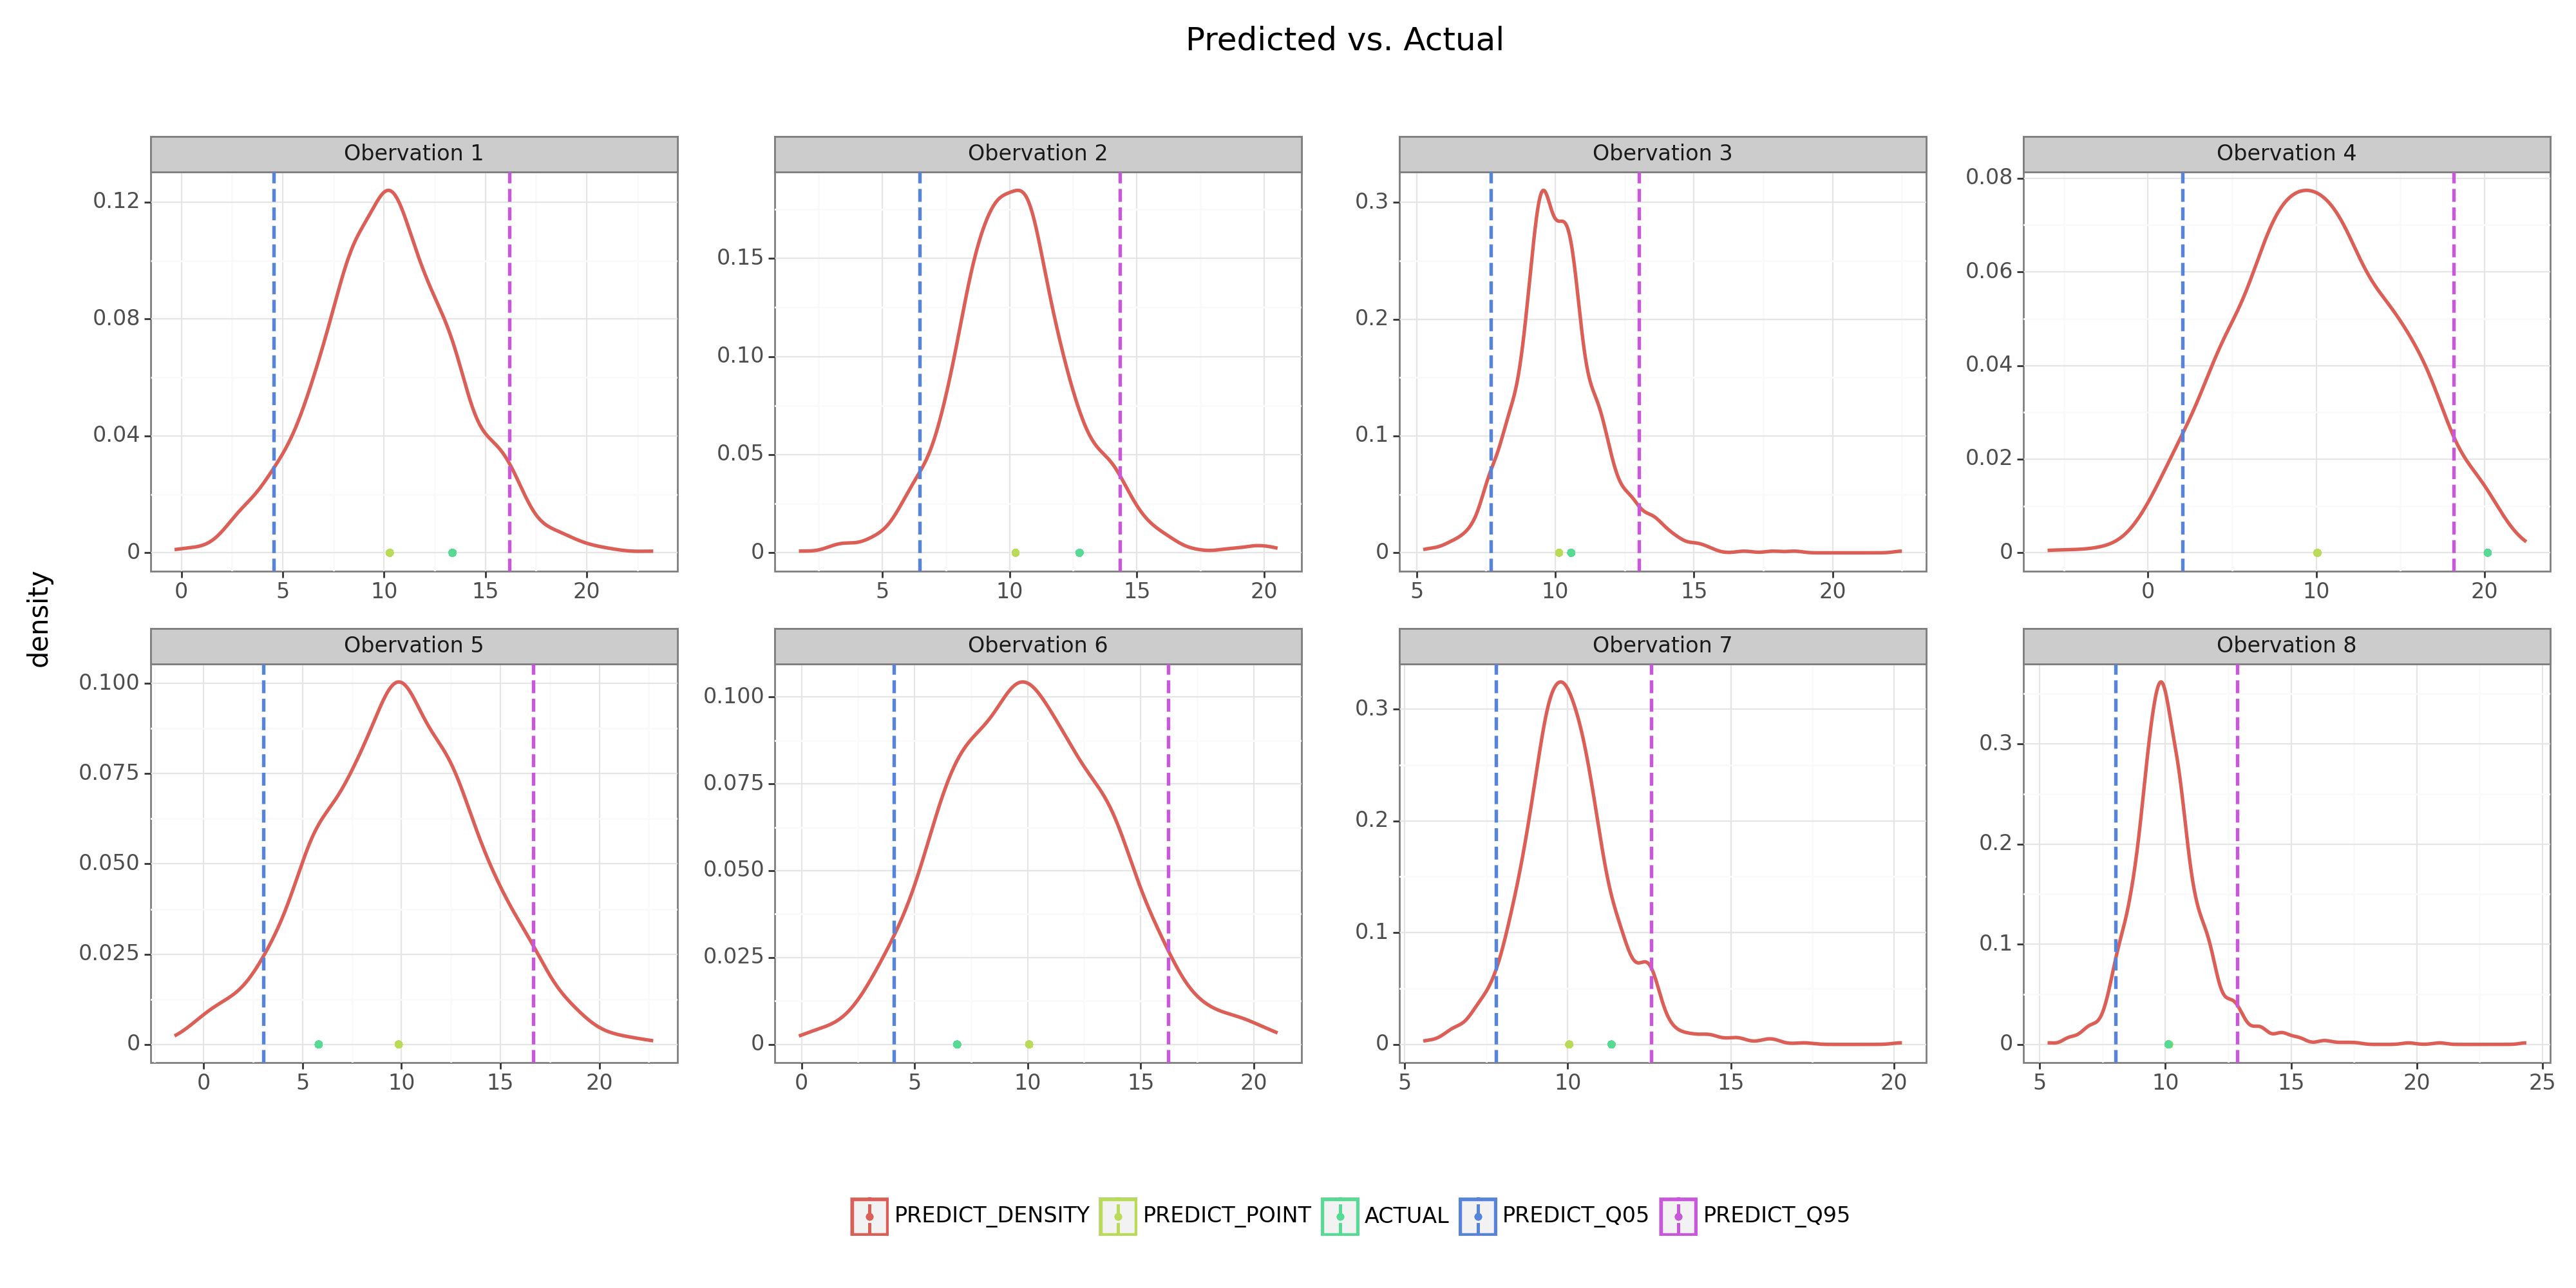

In [21]:
y_pred = []

n_examples = 8
q_sel = [0.05, 0.95]
y_sel=0
samples_arr = pred_samples.values.reshape(-1,n_samples)

for i in range(n_examples):    
    y_samples = pd.DataFrame(samples_arr[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=4) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    theme(plot_title = element_text(hjust = 0.5)) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

print(plot_pred)